In [1]:
using Plots, Optim, LinearAlgebra, LaTeXStrings

In [17]:
abstract type BoseHubbardModel end

struct MeanField <: BoseHubbardModel
    n_max :: Int64
    a :: Matrix{Float64}
    n :: Matrix{Float64}

    MeanField(n_max) = new(n_max, diagm(1 => sqrt.(1:n_max)), diagm(0 => 0:n_max))
end

expect(op, state) = (conj.(state') * op * state)[1]

function get_hamiltonian(model :: MeanField, t, mu, U, V, z, params)
    ψₐ, ψᵦ, ρₐ, ρᵦ = params
    H = -mu * model.n / (z * t) + (U/(2 * z * t)) * model.n * (model.n - I) + (V/t) * (ρᵦ * model.n - ρₐ * ρᵦ * I) - ψᵦ * (model.a + model.a') + ψₐ * ψᵦ * I
    return H 
end

function get_order_parameter(model, t, mu, U, V, z, init = nothing, depth = 1)
    ground_state((ψₐ, ψᵦ, ρₐ, ρᵦ)) = (eigvecs(get_hamiltonian(model, t, mu, U, V, z, [ψₐ, ψᵦ, ρₐ, ρᵦ]))[:, 1], eigvecs(get_hamiltonian(model, t, mu, U, V, z, [ψᵦ, ψₐ, ρᵦ, ρₐ]))[:, 1])
    
    params_new = isnothing(init) ? rand(-1000:1000, 4) : init
    params_old = copy(params_new)
    
    num_iter = 0
    while(true)
        params_old = copy(params_new)
        psi_gs = ground_state(params_new)
        params_new = [abs(expect(model.a, psi_gs[1])), abs(expect(model.a, psi_gs[2])), expect(model.n, psi_gs[1]), expect(model.n, psi_gs[2])]

        if((norm((params_old .- params_new)./params_old) <= 1e-3)) 
            return params_new        
        elseif(num_iter == 500)
            return params_new
            # if (depth < 3)
            #     return get_order_parameter(model, t, mu, U, V, z, nothing, depth + 1)
            # else 
            #     return params_new
            # end
        end

        num_iter += 1
    end

    return params_new
end

get_order_parameter (generic function with 3 methods)

In [18]:
model = MeanField(6)

z, num_points = 4, 50
U = range(start = 4, stop = 14, length = num_points)
mu = range(start = 0, stop = 25, length = num_points)
t = 1/4

order_param = zeros((num_points, num_points, 4))

for k1 in 1:num_points
    for k2 in 1:num_points
        order_param[k2, k1, :] .= (get_order_parameter(model, t, mu[k2], U[k1], 0.15 * U[k1], z))
    end
end

In [15]:
function get_phases(params)

    function identify(ψₐ, ψᵦ, ρₐ, ρᵦ)
        c = 4 # default

        if (ψₐ == ψᵦ)
            if ψₐ == 0
                if ρₐ == ρᵦ
                    c = 0 # MI
                else 
                    c = 1 # DW
                end
            elseif ρₐ == ρᵦ
                c = 2 # SF
            end
        elseif (ρₐ != ρᵦ)
            c = 3 # SS
        end
        
        return c
    end
    return identify.(vcat([order_param[:, :, i] for i in 1:4])...)
end

get_phases (generic function with 1 method)

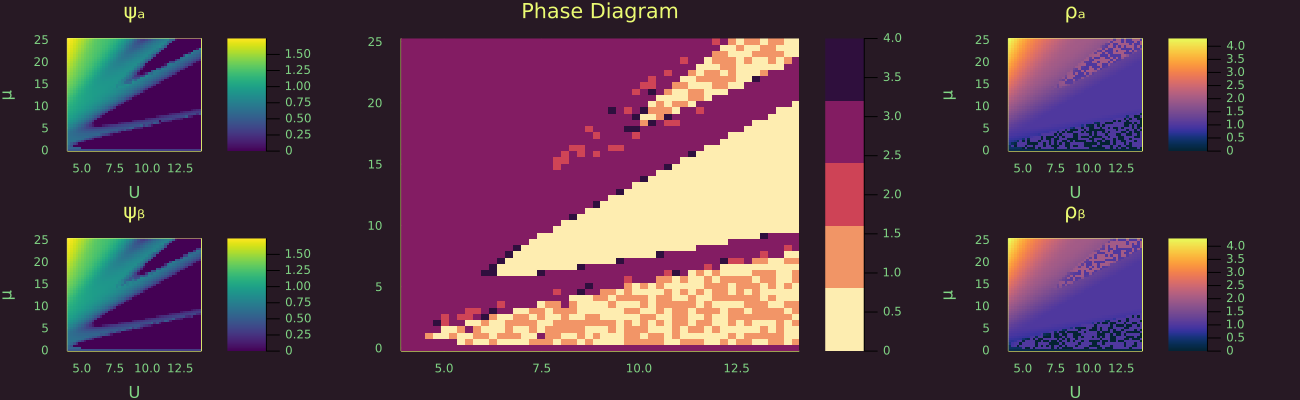

In [19]:
theme(:lime)
gr()
p = []
p_names = ["ψₐ", "ψᵦ", "ρₐ", "ρᵦ"]

for i in 1:4
    p_temp = (i <= 2) ? heatmap(U, mu, order_param[:, :, i]) : heatmap(U, mu, order_param[:, :, i], c = cgrad(:thermal, [1, 2, 3])) 
    plot!(
        ylabel = "μ",
        xlabel = "U",
        framestyle = :box, 
        title = p_names[i],
        margin = 5Plots.mm)

    push!(p, p_temp)
end

phases = heatmap(U, mu, get_phases(order_param), c = cgrad(:matter, 5, categorical = true), title = "Phase Diagram", colorbar = true)
l = @layout [
    [grid(2, 1)] c{0.5w} [grid(2, 1)]
]
plot(p[1], p[2], phases, p[3], p[4], size = (1300, 400), layout = l)